In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))


# Any results you write to the current directory are saved as output.

['sample_submission_ns2btKE.csv', 'train', 'test_ApKoW4T.csv']


In [2]:
train = pd.read_csv('../input/train/train.csv')
train.head()

,image,category
0,2823080.jpg,1
1,2870024.jpg,1
2,2662125.jpg,2
3,2900420.jpg,3
4,2804883.jpg,2


In [3]:
! pip install pretrainedmodels

    100% |████████████████████████████████| 61kB 4.6MB/s 
  Stored in directory: /tmp/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
Successfully built pretrainedmodels
You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [4]:
from fastai import *

In [5]:
from fastai.vision import *
from fastai.basics import *

In [6]:
import numpy as np
import pandas as pd

# Data visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Fastai
from fastai.vision import *
from fastai.metrics import error_rate
from fastai.vision.models import *
from fastai.vision.learner import model_meta
from fastai.torch_core import flatten_model

# PyTorch
import torch
from torchvision.models import *
import pretrainedmodels

from pathlib import Path
import sys

In [7]:
path= Path('../input/train/')

In [8]:
tfms=get_transforms(do_flip=False,flip_vert=True,max_rotate=10)
#tfms

In [9]:
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=False, reduction='elementwise_mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduction = reduction

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduction is None:
            return F_loss
        else:
            return torch.mean(F_loss)

In [10]:
sz = (224,224)
data = (ImageList.from_csv(path, folder='images', csv_name='train.csv', cols='image')
       .split_by_rand_pct(valid_pct=0.05, seed=34)
       .label_from_df(cols='category')
        .add_test_folder(Path('../input/test_ApKoW4T.csv'))
       .transform(tfms, size = sz)
       .databunch(bs=24)).normalize(imagenet_stats)

In [11]:
#data.show_batch(3, figsize=(6,6), hide_axis=False)

In [12]:
def arch_summary(arch):
    model = arch(False)
    tot = 0
    for i, l in enumerate(model.children()):
        n_layers = len(flatten_model(l))
        tot += n_layers
        print(f'({i}) {l.__class__.__name__:<12}: {n_layers:<4}layers (total: {tot})')

In [13]:
def vgg19Bn(pretrained=False):
    pretrained = 'imagenet' if pretrained else None
    model = pretrainedmodels.vgg19_bn(pretrained=pretrained)
    return model

def resnext(pretrained=False):
    pretrained = 'imagenet' if pretrained else None
    model = pretrainedmodels.resnext101_32x4d(pretrained=pretrained)
    return model

def se_resnet50(pretrained=False):
    pretrained = 'imagenet' if pretrained else None
    model = pretrainedmodels.se_resnet50(pretrained=pretrained)
    return model

def inceptionResNetV2(pretrained=False):
    pretrained = 'imagenet' if pretrained else None
    model = pretrainedmodels.inceptionresnetv2(pretrained=pretrained)
    return model

def xception(pretrained=False):
    pretrained = 'imagenet' if pretrained else None
    model = pretrainedmodels.xception(pretrained=pretrained)
    return model

def pnasnet5large(pretrained=False):
    pretrained = 'imagenet' if pretrained else None
    model = pretrainedmodels.pnasnet5large(pretrained=pretrained)
    return model

def senet154(pretrained=False):
    pretrained = 'imagenet' if pretrained else None
    model = pretrainedmodels.se_resnet50(pretrained=pretrained)
    return model

def se_resnext101_32x4d(pretrained=False):
    pretrained = 'imagenet' if pretrained else None
    model = pretrainedmodels.se_resnext101_32x4d(pretrained=pretrained)
    return model

In [14]:
from fastai.torch_core import *
from fastai.callback import *
from fastai.basic_train import *

__all__ = ['TerminateOnNaNCallback', 'EarlyStoppingCallback', 'SaveModelCallback', 'TrackerCallback',
        'ReduceLROnPlateauCallback', 'TrackEpochCallback' ]

class TerminateOnNaNCallback(Callback):
    "A `Callback` that terminates training if loss is NaN."

    def __init__(self):
        self.stop = False

    def on_batch_end(self, last_loss, epoch, num_batch, **kwargs:Any)->None:
        "Test if `last_loss` is NaN and interrupts training."
        if self.stop: return True #to skip validation after stopping during training
        if torch.isnan(last_loss):
            print (f'Epoch/Batch ({epoch}/{num_batch}): Invalid loss, terminating training.')
            return {'stop_epoch': True, 'stop_training': True, 'skip_validate': True}

class TrackerCallback(LearnerCallback):
    "A `LearnerCallback` that keeps track of the best value in `monitor`."
    def __init__(self, learn:Learner, monitor:str='valid_loss', mode:str='auto'):
        super().__init__(learn)
        self.monitor,self.mode = monitor,mode
        if self.mode not in ['auto', 'min', 'max']:
            warn(f'{self.__class__} mode {self.mode} is invalid, falling back to "auto" mode.')
            self.mode = 'auto'
        mode_dict = {'min': np.less, 'max':np.greater}
        mode_dict['auto'] = np.less if 'loss' in self.monitor else np.greater
        self.operator = mode_dict[self.mode]

    def on_train_begin(self, **kwargs:Any)->None:
        "Initializes the best value."
        self.best = float('inf') if self.operator == np.less else -float('inf')

    def get_monitor_value(self):
        "Pick the monitored value."
        if self.monitor=='trn_loss' and len(self.learn.recorder.losses) == 0: return None
        elif len(self.learn.recorder.val_losses) == 0: return None
        values = {'train_loss':self.learn.recorder.losses[-1].cpu().numpy(),
                  'valid_loss':self.learn.recorder.val_losses[-1]}
        if values['valid_loss'] is None: return
        if self.learn.recorder.metrics:
            for m, n in zip(self.learn.recorder.metrics[-1],self.learn.recorder.names[3:-1]):
                values[n] = m
        if values.get(self.monitor) is None:
            warn(f'{self.__class__} conditioned on metric `{self.monitor}` which is not available. Available metrics are: {", ".join(map(str, self.learn.recorder.names[1:-1]))}')
        return values.get(self.monitor)

class EarlyStoppingCallback(TrackerCallback):
    "A `TrackerCallback` that terminates training when monitored quantity stops improving."
    def __init__(self, learn:Learner, monitor:str='valid_loss', mode:str='auto', min_delta:int=0, patience:int=0):
        super().__init__(learn, monitor=monitor, mode=mode)
        self.min_delta,self.patience = min_delta,patience
        if self.operator == np.less:  self.min_delta *= -1

    def on_train_begin(self, **kwargs:Any)->None:
        "Initialize inner arguments."
        self.wait = 0
        super().on_train_begin(**kwargs)

    def on_epoch_end(self, epoch, **kwargs:Any)->None:
        "Compare the value monitored to its best score and maybe stop training."
        current = self.get_monitor_value()
        if current is None: return
        if self.operator(current - self.min_delta, self.best):
            self.best,self.wait = current,0
        else:
            self.wait += 1
            if self.wait > self.patience:
                print(f'Epoch {epoch}: early stopping')
                return {"stop_training":True}

class SaveModelCallback(TrackerCallback):
    "A `TrackerCallback` that saves the model when monitored quantity is best."
    def __init__(self, learn:Learner, monitor:str='valid_loss', mode:str='auto', every:str='improvement', name:str='bestmodel'):
        super().__init__(learn, monitor=monitor, mode=mode)
        self.every,self.name = every,name
        if self.every not in ['improvement', 'epoch']:
            warn(f'SaveModel every {self.every} is invalid, falling back to "improvement".')
            self.every = 'improvement'
                 
    def jump_to_epoch(self, epoch:int)->None:
        try: 
            self.learn.load(f'{self.name}_{epoch-1}', purge=False)
            print(f"Loaded {self.name}_{epoch-1}")
        except: print(f'Model {self.name}_{epoch-1} not found.')

    def on_epoch_end(self, epoch:int, **kwargs:Any)->None:
        "Compare the value monitored to its best score and maybe save the model."
        if self.every=="epoch": self.learn.save(f'{self.name}_{epoch}')
        else: #every="improvement"
            current = self.get_monitor_value()
            if current is not None and self.operator(current, self.best):
                print(f'Better model found at epoch {epoch} with {self.monitor} value: {current}.')
                self.best = current
                self.learn.save(f'{self.name}')

    def on_train_end(self, **kwargs):
        "Load the best model."
        if self.every=="improvement" and (self.learn.path/f'{self.learn.model_dir}/{self.name}.pth').is_file():
            self.learn.load(f'{self.name}', purge=False)

class ReduceLROnPlateauCallback(TrackerCallback):
    "A `TrackerCallback` that reduces learning rate when a metric has stopped improving."
    def __init__(self, learn:Learner, monitor:str='valid_loss', mode:str='auto', patience:int=0, factor:float=0.2,
                 min_delta:int=0):
        super().__init__(learn, monitor=monitor, mode=mode)
        self.patience,self.factor,self.min_delta = patience,factor,min_delta
        if self.operator == np.less:  self.min_delta *= -1

    def on_train_begin(self, **kwargs:Any)->None:
        "Initialize inner arguments."
        self.wait, self.opt = 0, self.learn.opt
        super().on_train_begin(**kwargs)

    def on_epoch_end(self, epoch, **kwargs:Any)->None:
        "Compare the value monitored to its best and maybe reduce lr."
        current = self.get_monitor_value()
        if current is None: return
        if self.operator(current - self.min_delta, self.best): self.best,self.wait = current,0
        else:
            self.wait += 1
            if self.wait > self.patience:
                self.opt.lr *= self.factor
                self.wait = 0
                print(f'Epoch {epoch}: reducing lr to {self.opt.lr}')


class TrackEpochCallback(LearnerCallback):
    _order = -20 #Need to run before fit_one_cycle
    def __init__(self, learn:Learner, name:str='epoch', epoch_offset:int=None):
        "Store completed epoch number in `learn.model_dir/name`."
        super().__init__(learn)
        learn._test_writeable_path()
        self.path = learn.path/learn.model_dir/name
        if epoch_offset is None:
            if os.path.isfile(self.path):
                 with self.path.open('r') as f:
                    try:    self.start_epoch = int(f.read())+1
                    except: self.start_epoch = 0
            else: self.start_epoch = 0
                
    def on_train_begin(self, **kwargs:Any):
        return {'epoch': self.start_epoch}

    def on_epoch_end(self, epoch, **kwargs:Any)->None:
        with self.path.open('w') as f: f.write(f'{epoch}')

    def restart(self): os.remove(self.path)

In [15]:
model_name = 'se_resnext101_32x4d'
from fastai.callback import *

def get_cadene_model(pretrained=True, model_name='se_resnext101_32x4d'):
    if pretrained:
        arch = pretrainedmodels.se_resnext101_32x4d(num_classes=1000, pretrained='imagenet')
    else:
        arch = pretrainedmodels.se_resnext101_32x4d(num_classes=1000, pretrained=None)
    return arch

# learn = cnn_learner(data,se_resnext101_32x4d(False),cut=-2,model_dir="/tmp/model/",metrics=[FBeta(beta=1),accuracy])
learn = create_cnn(data, partial(get_cadene_model,model_name=model_name), cut=-2,model_dir="/tmp/model/",metrics=[FBeta(beta=1),accuracy],
                  callback_fns=[partial(EarlyStoppingCallback, monitor='FBeta(beta=1)', min_delta=1e-1, patience=20)])

/opt/conda/lib/python3.6/site-packages/fastai/vision/learner.py:105: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/se_resnext101_32x4d-3b2fe3d8.pth" to /tmp/.torch/models/se_resnext101_32x4d-3b2fe3d8.pth
196466866it [09:12, 355480.72it/s]


In [16]:
useFocal = True
if useFocal:
    learn.loss_fn = FocalLoss()

In [17]:
learn.save("stage0_{}_{}".format(sz[0],sz[1]))#

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07


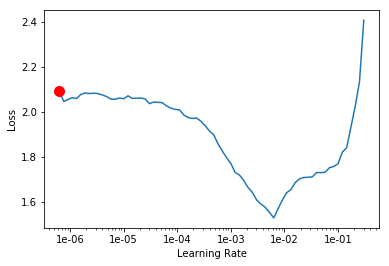

In [18]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [19]:
learn.fit(100,1e-5)

epoch,train_loss,valid_loss,f_beta,accuracy,time
0,1.192815,0.796963,0.688598,0.685897,02:03
1,0.653661,0.452683,0.839473,0.833333,02:03
2,0.424912,0.282545,0.917105,0.910256,02:03
3,0.338832,0.216008,0.932212,0.926282,02:03
4,0.247511,0.166118,0.946560,0.942308,02:03
5,0.194809,0.167107,0.936250,0.932692,02:03
6,0.149560,0.146238,0.948388,0.942308,02:03
7,0.135709,0.137222,0.953116,0.948718,02:03
8,0.109497,0.138840,0.960590,0.955128,02:03
9,0.090904,0.135589,0.951022,0.945513,02:03


/opt/conda/lib/python3.6/site-packages/fastai/metrics.py:179: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: <class '__main__.EarlyStoppingCallback'> conditioned on metric `FBeta(beta=1)` which is not available. Available metrics are: train_loss, valid_loss, f_beta, accuracy
/opt/conda/lib/python3.6/site-packages/fastai/metrics.py:179: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: <class '__main__.EarlyStoppingCallback'> conditioned on metric `FBeta(beta=

In [20]:
t  = pd.read_csv('../input/test_ApKoW4T.csv')
t.shape[0]

2680

In [21]:
data.add_test(items=[path/'images'/i for i in t['image'].tolist()],label=None)

In [22]:
data.test_dl

DeviceDataLoader(dl=<torch.utils.data.dataloader.DataLoader object at 0x7fb66c0c7780>, device=device(type='cuda'), tfms=[functools.partial(<function _normalize_batch at 0x7fb68f624ae8>, mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]), do_x=True, do_y=False)], collate_fn=<function data_collate at 0x7fb6a6807268>)

In [23]:
preds, y = learn.TTA(beta=0.4,ds_type=DatasetType.Test)

In [24]:
preds.shape

torch.Size([2680, 5])

In [25]:
imgName = t['image'].tolist()
imgName

['1007700.jpg',
 '1011369.jpg',
 '1051155.jpg',
 '1062001.jpg',
 '1069397.jpg',
 '1072861.jpg',
 '1097264.jpg',
 '1098763.jpg',
 '1098766.jpg',
 '1101145.jpg',
 '1114371.jpg',
 '1114781.jpg',
 '1115492.jpg',
 '1121306.jpg',
 '1123736.jpg',
 '1124946.jpg',
 '1125700.jpg',
 '1127236.jpg',
 '1127336.jpg',
 '1130300.jpg',
 '1131990.jpg',
 '1141996.jpg',
 '1145082.jpg',
 '1153400.jpg',
 '1162763.jpg',
 '1162764.jpg',
 '1162765.jpg',
 '1163874.jpg',
 '1174623.jpg',
 '1185778.jpg',
 '1186207.jpg',
 '1193420.jpg',
 '1203926.jpg',
 '1228622.jpg',
 '1229806.jpg',
 '1243717.jpg',
 '1244690.jpg',
 '1244768.jpg',
 '1250078.jpg',
 '1250085.jpg',
 '1252407.jpg',
 '1260394.jpg',
 '1263061.jpg',
 '1263459.jpg',
 '1289223.jpg',
 '1289225.jpg',
 '1296498.jpg',
 '1311396.jpg',
 '1314965.jpg',
 '1324036.jpg',
 '1334848.jpg',
 '1334855.jpg',
 '1342277.jpg',
 '1345016.jpg',
 '1352852.jpg',
 '1359851.jpg',
 '1368439.jpg',
 '1382476.jpg',
 '1386041.jpg',
 '1396598.jpg',
 '1400085.jpg',
 '1400092.jpg',
 '141293

In [26]:
preds_  = torch.argmax(preds,1)+1
preds_

tensor([4, 4, 4,  ..., 4, 4, 4])

In [27]:
preds_ = preds_.numpy()
preds_

array([4, 4, 4, 2, ..., 4, 4, 4, 4])

In [28]:
pd.Series(preds_).value_counts()

1    897
5    531
2    502
3    394
4    356
dtype: int64

In [29]:
predsDF = pd.DataFrame()
predsDF['image'] = imgName
predsDF['category'] = preds_
predsDF.head(20)

,image,category
0,1007700.jpg,4
1,1011369.jpg,4
2,1051155.jpg,4
3,1062001.jpg,2
4,1069397.jpg,4
5,1072861.jpg,4
6,1097264.jpg,4
7,1098763.jpg,2
8,1098766.jpg,2
9,1101145.jpg,4


In [30]:
t.head(20)

,image
0,1007700.jpg
1,1011369.jpg
2,1051155.jpg
3,1062001.jpg
4,1069397.jpg
5,1072861.jpg
6,1097264.jpg
7,1098763.jpg
8,1098766.jpg
9,1101145.jpg


In [31]:
sum(predsDF['image'] == t['image']) == t.shape[0]

True

In [32]:
predsDF.to_csv('preds_se_resnext101_32x4d.csv',index=False)
from IPython.display import FileLink, FileLinks
FileLink('preds_se_resnext101_32x4d.csv')

/kaggle/working/preds_se_resnext101_32x4d.csv